In [1]:
# =======================
# 1. Import Libraries
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib

In [3]:
# =======================
# 2. Load Dataset
# =======================
df = pd.read_csv("weatherAUS.csv")
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [5]:
# =======================
# 3. EDA
# =======================
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [6]:
print(df.isnull().sum().sort_values(ascending=False).head(10))

Sunshine         67816
Evaporation      60843
Cloud3pm         57094
Cloud9am         53657
Pressure9am      14014
Pressure3pm      13981
WindDir9am       10013
WindGustDir       9330
WindGustSpeed     9270
WindDir3pm        3778
dtype: int64


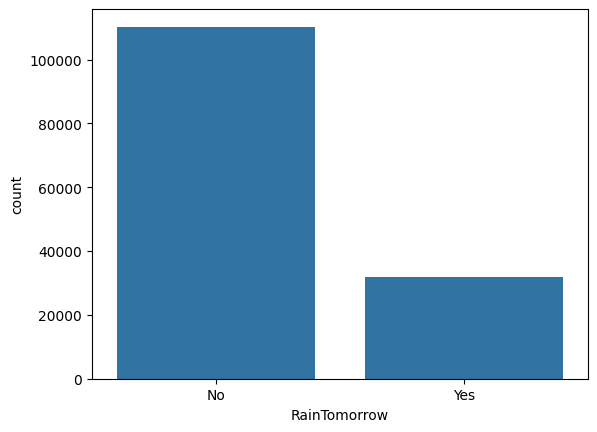

In [7]:
# Target variable: "RainTomorrow"
sns.countplot(x="RainTomorrow", data=df)
plt.show()


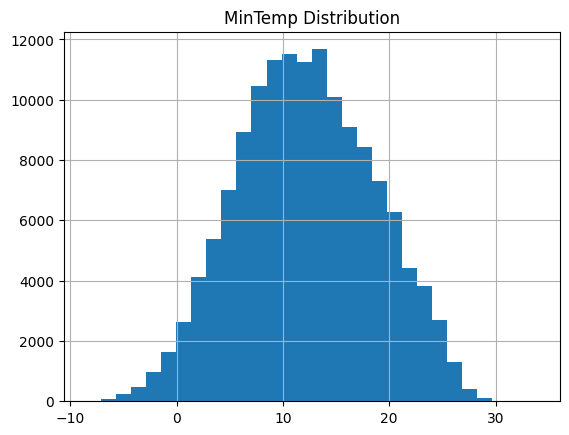

In [8]:
# Example numeric distribution
df["MinTemp"].hist(bins=30)
plt.title("MinTemp Distribution")
plt.show()


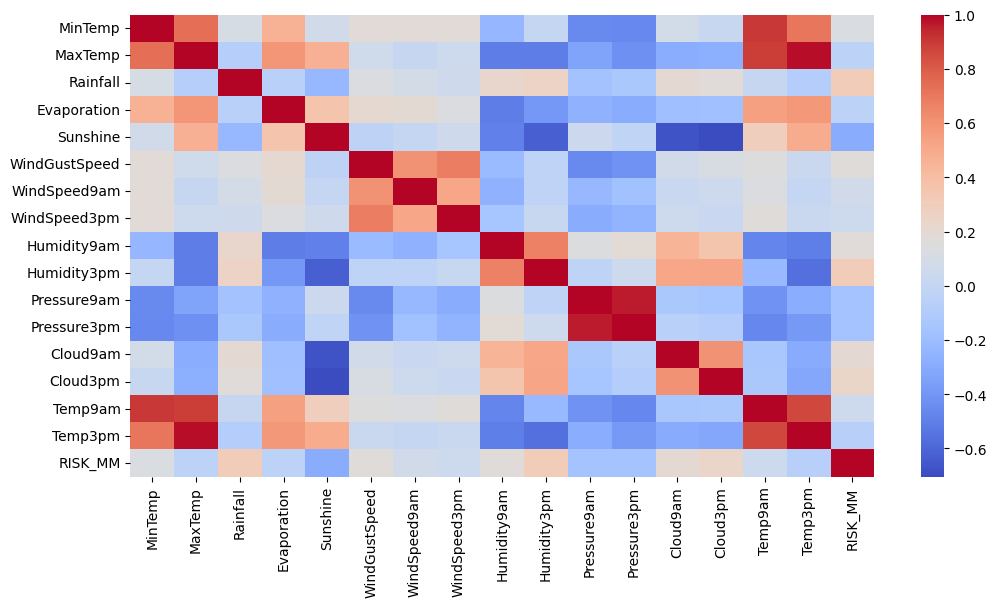

In [9]:
# Correlation heatmap (numeric only)
plt.figure(figsize=(12,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), cmap="coolwarm", annot=False)
plt.show()

In [10]:
# =======================
# 4. Preprocessing
# =======================

# Separate features and target
X = df.drop("RainTomorrow", axis=1)
y = df["RainTomorrow"].map({"No":0, "Yes":1})   # convert to binary


In [11]:
# Identify column types
num_features = X.select_dtypes(include=["int64","float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns


In [12]:
# Pipelines for preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [13]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

In [15]:
# =======================
# 5. Model Pipelines
# =======================

# Logistic Regression
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

In [16]:
# Random Forest
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])

In [17]:
# Gradient Boosting
gb_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(n_estimators=200, random_state=42))
])

In [18]:
# =======================
# 6. Train-Test Split
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# 7. Train & Evaluate Models
# =======================
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_clf,
    "Gradient Boosting": gb_clf
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("\n")


=== Logistic Regression ===
Accuracy: 0.9969408207039628
ROC-AUC: 0.9999903595956149
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22064
           1       1.00      0.99      0.99      6375

    accuracy                           1.00     28439
   macro avg       1.00      0.99      1.00     28439
weighted avg       1.00      1.00      1.00     28439

[[22062     2]
 [   85  6290]]




In [ ]:
# =======================
# 8. Hyperparameter Tuning Example (RandomForest)
# =======================
param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [5, 10, None],
    "classifier__min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(rf_clf, param_grid, cv=3, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


In [ ]:
# =======================
# 9. Save Final Model
# =======================
joblib.dump(grid_search.best_estimator_, "weather_rain_model.pkl")
print("Model saved as weather_rain_model.pkl")
